In [109]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [110]:
import numpy as np
import pandas as pd

In [111]:
import datetime as dt

In [112]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [113]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [114]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [115]:
Base.classes.keys()

['measurement', 'station']

In [116]:
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [117]:
session = Session(engine)

## Exploratory Climate Analysis

In [118]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23a6f201588>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [119]:
latest_d = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_d

('2017-08-23')

In [120]:
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [121]:
for_df = []
for row in session.query(Measurement).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all():
    for_df.append({'Date': row.date,
                   'Precipitation': row.prcp})
    
out = pd.DataFrame.from_records(for_df)
out.set_index('Date',inplace=True)
out.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


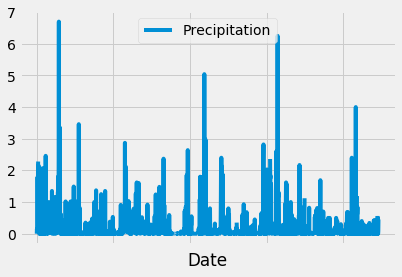

In [122]:
out.plot()

In [123]:
out.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [124]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x23a6f2e5d30>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'elevation': 3.0,
 'station': 'USC00519397'}

In [125]:
total_number_of_station = session.query(func.count(Station.station)).all()
total_number_of_station

[(9)]

In [126]:
session.query(Measurement.station,func.count(Measurement.id)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [127]:
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.id).desc()).first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [128]:
lastest_d_for_the_station = session.query(Measurement.date).\
            filter(Measurement.station =='USC00519281').\
            order_by(Measurement.date.desc()).first()
lastest_d_for_the_station

('2017-08-18')

In [129]:
df_1 = pd.DataFrame.from_records(session.query(Measurement.date,Measurement.tobs).\
                        filter(Measurement.station =='USC00519281').\
                        filter(Measurement.date >= '2016-08-18').all())
df_1.columns = ['Date','Tobs']
df_1.head()

,Date,Tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


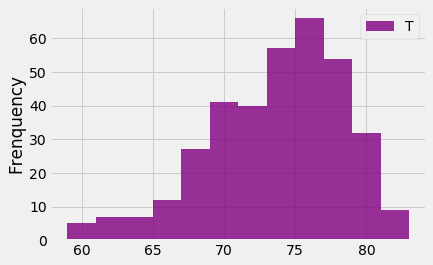

In [130]:
num_bins = 12
plt.hist(df_1['Tobs'], num_bins, color='purple', alpha=0.8)
plt.ylabel('Frenquency')
plt.legend('Tobs')

## Temperature Analysis

In [131]:
def calc_temps(start_date, end_date):    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-01-28', '2017-02-16'))

[(59.0, 69.56589147286822, 80.0)]


Text(0.5,1,'Trip Avg Temp')

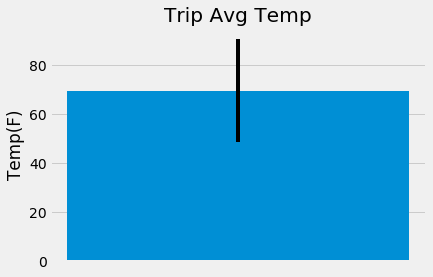

In [132]:
y = 69.56589147286822
x = 0
yerr = 80 - 59
plt.bar (x, y, yerr=yerr)
plt.xticks([])
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

In [133]:
for f_date in session.query(Measurement.date).order_by(Measurement.date).first():
    print(f_date)

    
for l_date in session.query(Measurement.date).order_by(Measurement.date.desc()).first():
    print(l_date)

2010-01-01
2017-08-23


## Other Recommended Analysis 

In [134]:
# def get_calc_temp_for_s(start_date,end_date):
#     res = []
    
#     for row in session.query(Measurement.station,func.sum(Measurement.prcp)).\
#     filter(Measurement.date >= start_date).\
#     filter(Measurement.date <= end_date).\
#     group_by(Measurement.station).\
#     order_by(func.sum(Measurement.prcp).desc()).all():
#         res.append(row)
#     return res
        
# temps = get_calc_temp_for_s('2012-07-08','2017-09-08')

# dict(temps)

In [135]:
# def get_station_information():
#     res = []
    
#     for row in session.query(Station.latitude, Station.station,Station.longitude):
#         res.append(row)
#     return res

# stations = get_station_information()

In [136]:
# jeff = pd.DataFrame.from_records(stations)
# jeff.columns = ['lat', 'station', 'long']
# jeff['station_metric'] = jeff['station'].map(lambda x: dict(temps).get(x))
# jeff.query('station ==  "USC00516128" ')

In [137]:
for row in session.query(Measurement.station,Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2016-05-01').\
    filter(Measurement.date <= '2016-06-01').\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station, Station.latitude, Station.longitude,Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all():
    print (row)

('USC00516128', 21.3331, -157.8025, 152.4, 10.540000000000001)
('USC00519281', 21.45167, -157.84888999999998, 32.9, 7.969999999999999)
('USC00513117', 21.4234, -157.8015, 14.6, 6.109999999999999)
('USC00519523', 21.33556, -157.71139, 19.5, 5.039999999999999)
('USC00514830', 21.5213, -157.8374, 7.0, 2.83)
('USC00519397', 21.2716, -157.8168, 3.0, 1.2000000000000002)
('USC00517948', 21.3934, -157.9751, 11.9, 0.44)


In [138]:
def daily_normals(date):  
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
date = ['01-01','01-02','01-03','01-04','01-05','01-06','01-07','01-08']
res = [daily_normals(i) for i in date]
df_2 = pd.DataFrame.from_records(res)
df_2.index = date
df_2

,0
01-01,"(62.0, 69.15384615384616, 77.0)"
01-02,"(60.0, 69.39622641509433, 77.0)"
01-03,"(62.0, 68.9090909090909, 77.0)"
01-04,"(58.0, 70.0, 76.0)"
01-05,"(56.0, 67.96428571428571, 76.0)"
01-06,"(61.0, 68.96491228070175, 76.0)"
01-07,"(57.0, 68.54385964912281, 76.0)"
01-08,"(57.0, 67.16071428571429, 75.0)"


In [139]:
df_2['Tmin'] = df_2[0].map(lambda x: x[0])
df_2['Tavg'] = df_2[0].map(lambda x: x[1])
df_2['Tmax'] = df_2[0].map(lambda x: x[2])
df_2

,0,Tmin,Tavg,Tmax
01-01,"(62.0, 69.15384615384616, 77.0)",62.0,69.153846,77.0
01-02,"(60.0, 69.39622641509433, 77.0)",60.0,69.396226,77.0
01-03,"(62.0, 68.9090909090909, 77.0)",62.0,68.909091,77.0
01-04,"(58.0, 70.0, 76.0)",58.0,70.000000,76.0
01-05,"(56.0, 67.96428571428571, 76.0)",56.0,67.964286,76.0
01-06,"(61.0, 68.96491228070175, 76.0)",61.0,68.964912,76.0
01-07,"(57.0, 68.54385964912281, 76.0)",57.0,68.543860,76.0
01-08,"(57.0, 67.16071428571429, 75.0)",57.0,67.160714,75.0


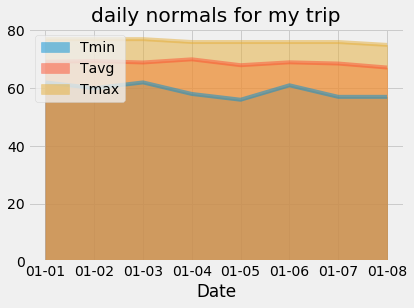

In [140]:
df_2.plot(kind='area', stacked=False, alpha=0.5, title='daily normals for my trip')
plt.xticks(range(8),date)
plt.xlabel("Date")
plt.legend(loc='upper left')